In [2]:
!pip install --quiet requests pandas numpy matplotlib scikit-learn tqdm faiss-cpu



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os, time, json, requests
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import faiss
from tqdm import tqdm


HF_API_TOKEN = os.getenv("HF_API_TOKEN")


headers = {
    "Authorization": f"Bearer {HF_API_TOKEN}",
    "Content-Type": "application/json"
}

MODEL_NAME = "BAAI/bge-large-en-v1.5"
# EMBED_URL = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{MODEL_NAME}"
EMBED_URL = f"https://router.huggingface.co/hf-inference/models/{MODEL_NAME}/pipeline/feature-extraction"

# Local storage paths
os.makedirs("faiss", exist_ok=True)
EMBED_PATH = "faiss/product_embeddings.pkl"
FAISS_PATH = "faiss/vibe_products.faiss"


In [17]:
def get_hf_embeddings(texts):
    """
    Returns embeddings (list of lists) for a list of texts from Hugging Face Inference API.
    """
    embeddings = []
    for t in tqdm(texts, desc="Generating embeddings via HF API"):
        payload = {"inputs": t}
        response = requests.post(EMBED_URL, headers=headers, json=payload)
        if response.status_code != 200:
            raise Exception(f"HF API Error: {response.status_code}, {response.text}")
        emb = response.json()
        # Flatten nested lists (some models return [[...]])
        if isinstance(emb[0], list):
            emb = emb[0]
        embeddings.append(emb)
    return np.array(embeddings, dtype="float32")


In [18]:
data = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones perfect for outdoor festivals and summer days.", "vibes":["boho","earthy","relaxed"]},
    {"name": "Street Hoodie", "desc": "Bold graphic prints with an urban streetwear appeal, oversized fit.", "vibes":["urban","energetic","casual"]},
    {"name": "Classic Blazer", "desc": "Elegant tailored blazer for formal or smart-casual looks.", "vibes":["chic","formal","professional"]},
    {"name": "Cozy Knit Sweater", "desc": "Soft oversized knit sweater for laid-back and comfy weekends.", "vibes":["cozy","relaxed","minimal"]},
    {"name": "Denim Jacket", "desc": "Timeless denim jacket with rugged detailing — great for layering.", "vibes":["casual","vintage","cool"]},
    {"name": "Evening Gown", "desc": "Floor-length elegant gown with modern cuts and confident flair.", "vibes":["luxury","formal","feminine"]},
    {"name": "Athleisure Set", "desc": "Stretchy, modern athleisure set designed for workouts and errands.", "vibes":["sporty","active","modern"]},
    {"name": "Pastel Sundress", "desc": "Light pastel sundress with floral print, perfect for beach walks.", "vibes":["beachy","romantic","summer"]},
    {"name": "Leather Moto Jacket", "desc": "Edgy leather jacket inspired by motorcycle culture.", "vibes":["edgy","street","bold"]},
    {"name": "Tailored Trousers", "desc": "Slim tailored trousers for business-casual outfits.", "vibes":["professional","minimal","chic"]},
    {"name": "Sequin Dress", "desc": "Eye-catching sequin dress ideal for parties and nightlife.", "vibes":["party","glam","bold"]},
    {"name": "Vintage Cardigan", "desc": "Retro patterned cardigan that brings nostalgia and warmth.", "vibes":["vintage","cozy","retro"]},
    {"name": "Silk Scarf", "desc": "Elegant silk scarf with floral motifs, adds a luxurious accent.", "vibes":["luxury","elegant","classic"]},
    {"name": "Cargo Pants", "desc": "Functional cargo pants with pockets, perfect for outdoor adventures.", "vibes":["rugged","outdoor","practical"]},
    {"name": "Wool Overcoat", "desc": "Classic wool coat designed for urban professionals.", "vibes":["formal","urban","timeless"]},
    {"name": "Running Shoes", "desc": "Lightweight performance running shoes with modern design.", "vibes":["sporty","active","casual"]},
    {"name": "Beach Shorts", "desc": "Comfortable and vibrant shorts for summer beach vacations.", "vibes":["beachy","vibrant","casual"]},
    {"name": "Floral Maxi Dress", "desc": "Romantic floral maxi dress with a breezy silhouette.", "vibes":["romantic","boho","summer"]},
    {"name": "Puffer Jacket", "desc": "Warm puffer jacket ideal for chilly winters, stylish and durable.", "vibes":["winter","cozy","functional"]},
    {"name": "Denim Overalls", "desc": "Casual denim overalls that blend comfort with retro appeal.", "vibes":["casual","retro","cool"]}
]
df = pd.DataFrame(data)
df.index.name = "product_id"
df.head()


,name,desc,vibes
product_id,,,
0,Boho Dress,"Flowy, earthy tones perfect for outdoor festiv...","[boho, earthy, relaxed]"
1,Street Hoodie,Bold graphic prints with an urban streetwear a...,"[urban, energetic, casual]"
2,Classic Blazer,Elegant tailored blazer for formal or smart-ca...,"[chic, formal, professional]"
3,Cozy Knit Sweater,Soft oversized knit sweater for laid-back and ...,"[cozy, relaxed, minimal]"
4,Denim Jacket,Timeless denim jacket with rugged detailing — ...,"[casual, vintage, cool]"


In [ ]:
if os.path.exists(FAISS_PATH):
    print("Loading existing FAISS index...")
    index = faiss.read_index(FAISS_PATH)
    df = pd.read_pickle(EMBED_PATH)
else:
    print("Embedding all 20 products via Hugging Face API ...")
    emb_matrix = get_hf_embeddings(df["desc"].tolist())
    emb_matrix = normalize(emb_matrix, axis=1)
    df["embedding"] = list(emb_matrix)

    dim = emb_matrix.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(emb_matrix)

    faiss.write_index(index, FAISS_PATH)
    df.to_pickle(EMBED_PATH)
    print("✅ Saved FAISS index & embeddings locally in /faiss")


Embedding all 20 products via Hugging Face API ...


Generating embeddings via HF API: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]

✅ Saved FAISS index & embeddings locally in /faiss


In [20]:
queries = [
    "energetic urban chic",
    "boho summer outfit",
    "cozy winter layers",
    "luxury evening gown",
    "sporty casual look",
    "retro vintage nostalgia",
    "romantic beach outfit",
    "party night sparkle dress",
    "formal office attire",
    "outdoor adventure gear"
]


In [21]:
def embed_query(query):
    payload = {"inputs": query}
    r = requests.post(EMBED_URL, headers=headers, json=payload)
    vec = np.array(r.json(), dtype="float32")
    if vec.ndim > 1: vec = vec[0]
    vec = normalize(vec.reshape(1, -1))
    return vec

def vibe_match(query, k=3, fallback_threshold=0.6):
    start = time.time()
    qv = embed_query(query)
    scores, idx = index.search(qv, k)
    latency = time.time() - start
    results = df.iloc[idx[0]][["name", "desc", "vibes"]].copy()
    results["score"] = scores[0]

    print(f"\n Query: {query}")
    if results["score"].max() < fallback_threshold:
        print(" No strong match found — suggest refining the vibe query.")
        print("Fallback Suggestion:", results.iloc[0]["name"])
    else:
        for i, row in results.iterrows():
            print(f"{row['name']} — Score: {row['score']:.3f}")

    return results, latency

metrics = []
for q in queries:
    res, lat = vibe_match(q)
    best = res["score"].max()
    good = (res["score"] > 0.7).sum()
    metrics.append({"query": q, "best_score": best, "good_matches": good, "latency": lat})

metrics_df = pd.DataFrame(metrics)
metrics_df



 Query: energetic urban chic
Street Hoodie — Score: 0.699
Boho Dress — Score: 0.671
Sequin Dress — Score: 0.670

 Query: boho summer outfit
Floral Maxi Dress — Score: 0.656
Athleisure Set — Score: 0.642
Boho Dress — Score: 0.636

 Query: cozy winter layers
Cozy Knit Sweater — Score: 0.680
Puffer Jacket — Score: 0.645
Vintage Cardigan — Score: 0.635

 Query: luxury evening gown
Evening Gown — Score: 0.773
Classic Blazer — Score: 0.683
Sequin Dress — Score: 0.682

 Query: sporty casual look
Denim Overalls — Score: 0.711
Classic Blazer — Score: 0.699
Athleisure Set — Score: 0.696

 Query: retro vintage nostalgia
Vintage Cardigan — Score: 0.797
Denim Overalls — Score: 0.713
Cozy Knit Sweater — Score: 0.584

 Query: romantic beach outfit
Floral Maxi Dress — Score: 0.735
Pastel Sundress — Score: 0.709
Beach Shorts — Score: 0.677

 Query: party night sparkle dress
Sequin Dress — Score: 0.793
Floral Maxi Dress — Score: 0.656
Evening Gown — Score: 0.584

 Query: formal office attire
Tailored T

,query,best_score,good_matches,latency
0,energetic urban chic,0.698632,0,6.201258
1,boho summer outfit,0.656104,0,1.432305
2,cozy winter layers,0.679658,0,3.575105
3,luxury evening gown,0.773217,1,3.091783
4,sporty casual look,0.710960,1,2.121432
5,retro vintage nostalgia,0.797126,2,3.060077
6,romantic beach outfit,0.734579,2,1.436291
7,party night sparkle dress,0.792647,1,2.551800
8,formal office attire,0.714060,2,2.149048
9,outdoor adventure gear,0.722076,1,1.913071


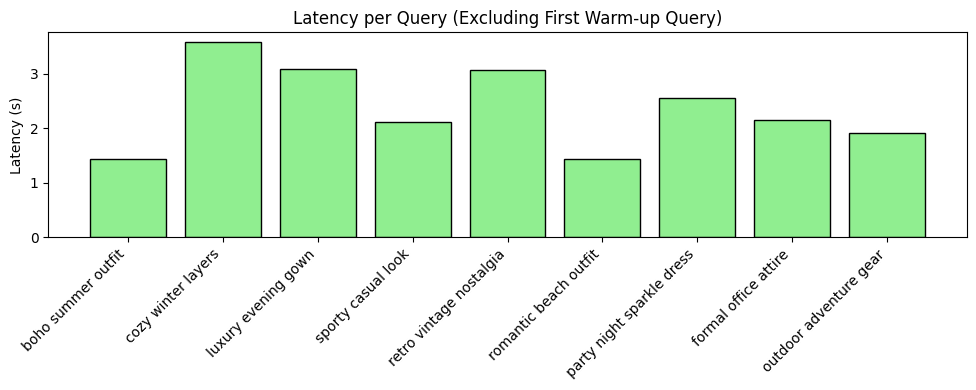

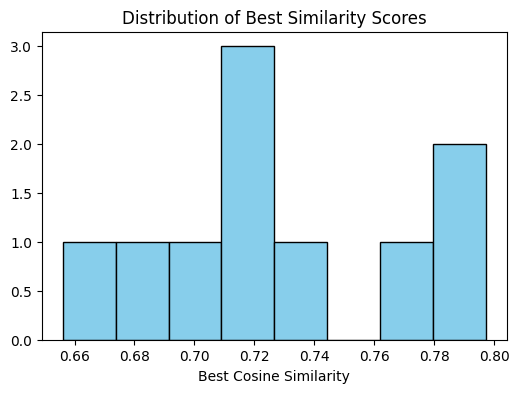


Average Latency (excluding warm-up): 2.370s
Queries with Good Match (>0.7): 7/10


In [ ]:

metrics_filtered = metrics_df.iloc[1:]  # excluded session warm-up

# Plot latency per query (after warm-up)
plt.figure(figsize=(10, 4))
plt.bar(metrics_filtered["query"], metrics_filtered["latency"], color="lightgreen", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Latency (s)")
plt.title("Latency per Query (Excluding First Warm-up Query)")
plt.tight_layout()
plt.show()

# Plot similarity distribution (all queries)
plt.figure(figsize=(6, 4))
plt.hist(metrics_df["best_score"], bins=8, color="skyblue", edgecolor="black")
plt.xlabel("Best Cosine Similarity")
plt.title("Distribution of Best Similarity Scores")
plt.show()

# Compute stats excluding warm-up query
avg_latency = metrics_filtered["latency"].mean()
good_matches = (metrics_df["good_matches"] > 0).sum()

print(f"\nAverage Latency (excluding warm-up): {avg_latency:.3f}s")
print(f"Queries with Good Match (>0.7): {good_matches}/{len(metrics_df)}")


### Why AI at Nexora?

Artificial Intelligence at Nexora represents the bridge between creativity and technology — enabling faster, more intelligent, and deeply personalized digital experiences. Through AI, Nexora aims to move beyond static products toward adaptive, data-driven systems that understand user intent and context. This assignment demonstrates that philosophy by applying AI-driven semantic search and embeddings to fashion recommendations, showing how natural language understanding can enhance user engagement and decision-making. By leveraging open-source models, efficient vector databases, and smart retrieval techniques, this project aligns with Nexora’s vision of building scalable, intelligent systems that can power real-world personalization at speed and scale.
